In [1]:
freq_dict = {'15-min':'15T',
            '1-hour':'1H',
            '2-hour':'2H',
            '4-hour':'4H',
            '6-hour':'6H',
            '8-hour':'8H',
            '12-hour':'12H',
            '1-day':'1D',
            '2-day':'2D',
            '7-day':'7D',
            '15-day':'15D',
            '1-month':'1M'}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from copy import deepcopy


In [3]:
metadata_df = pd.read_csv("./metadata.csv",index_col=0)
feeds = {'use':'aggregate',
        'air1':'hvac',
         'clotheswasher1':'wm',
         'dishwasher1':'dw',
         'microwave1':'mw',
         'refrigerator1':'fridge',
         'oven1':'oven',
        'car1':'ec',
         'waterheater1':'wh',
         'drye1':'dr'
        }

In [4]:
city = 'Austin'
year = 2015

In [5]:
st = pd.HDFStore(os.path.expanduser("~/all.h5"), mode='r')

In [10]:
d = st['/26']['2015']['use']

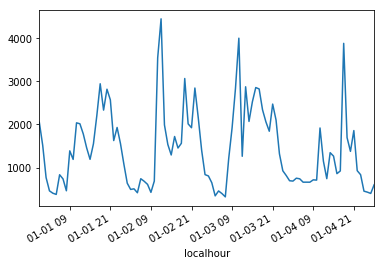

In [13]:
%matplotlib inline
d.head(100).plot()

In [14]:
APPLIANCES_ORDER = ['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [15]:
#for freq in ['2H','4H','12H','1H']:
for freq in ['1H']:
    print(freq)
    freq_num = int(freq[:-1])
    out = []
    homes = []
    city_data = metadata_df[metadata_df['city'] == city]
    city_homes = city_data.index.values.astype('int')
    for home in city_homes[:]:

        try:
            data_df = st['/%d' %home]['%s' %year]

            # Only consider homes that have data from Jan 1 to Dec 31
            day_of_year = data_df.index.dayofyear
            if day_of_year[0]==1 and day_of_year[-1]==365:
                downsampled_data = data_df.resample(freq).mean()
                if len(downsampled_data)<((365*24)//freq_num):
                    continue
                downsampled_data = downsampled_data.rename(columns=feeds)
                o =  [None] * len(APPLIANCES_ORDER)
                for a_num, appliance in enumerate(APPLIANCES_ORDER):
                    if appliance in downsampled_data.columns:
                        o[a_num] = downsampled_data[appliance].values.reshape(365, 24//freq_num)
                    else:
                        o[a_num] = np.zeros((365, 24//freq_num))
                        o[a_num].fill(np.nan)
                out.append(o)
                homes.append(home)

            else:
                continue
        except Exception as e:
            print(e)
    out = np.array(out)
    
    np.save('{}-input.npy'.format(freq), out)

1H
'No object named /2836 in the file'
'No object named /2743 in the file'
'No object named /5323 in the file'
'No object named /8560 in the file'
'No object named /3313 in the file'
'No object named /5052 in the file'
'No object named /3936 in the file'
'No object named /1622 in the file'
'No object named /1114 in the file'
'No object named /5433 in the file'
'No object named /1101 in the file'
'2015'
'2015'
'No object named /3824 in the file'
'No object named /78 in the file'
'2015'
'No object named /5839 in the file'
'No object named /1050 in the file'
'2015'
'2015'
'No object named /18 in the file'
'No object named /35 in the file'
'No object named /964 in the file'
'No object named /1852 in the file'
'No object named /2345 in the file'
'No object named /2645 in the file'
'No object named /2653 in the file'
'No object named /3739 in the file'
'No object named /4228 in the file'
'No object named /4421 in the file'
'No object named /4671 in the file'
'No object named /4726 in the fil

'No object named /9599 in the file'
'No object named /6953 in the file'
'2015'
'2015'
'2015'
'2015'
'No object named /862 in the file'
'No object named /9950 in the file'
'No object named /3147 in the file'
'2015'
'No object named /136 in the file'
'2015'
'2015'
'No object named /44 in the file'
'No object named /365 in the file'
'No object named /4953 in the file'
'No object named /6424 in the file'
'No object named /7474 in the file'
'No object named /8596 in the file'
'2015'
'2015'
'No object named /1462 in the file'
'No object named /543 in the file'
'No object named /6345 in the file'
'No object named /3246 in the file'
'No object named /325 in the file'
'No object named /1275 in the file'
'No object named /2172 in the file'
'No object named /2377 in the file'
'No object named /3498 in the file'
'No object named /3730 in the file'
'No object named /3977 in the file'
'No object named /4731 in the file'
'No object named /4734 in the file'
'No object named /5320 in the file'
'No obje

In [17]:
np.save('{}-input.npy'.format(freq), out)

In [16]:
import sys
sys.path.append("../code/")

In [17]:
from tensor_custom_core import *

In [18]:
home, appliance, day, hour = stf_4dim(out[:10, :, :, :], 2)

773.306544215 0
365.768216336 50


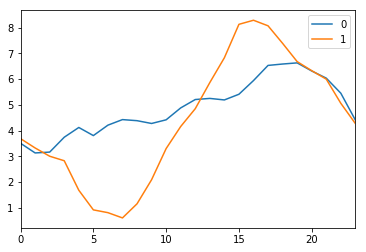

In [19]:
pd.DataFrame(hour).plot()

In [17]:
%matplotlib inline

In [25]:
pd.DataFrame(out[homes.index(410)][APPLIANCES_ORDER.index("hvac")]).T.plot(legend=False, color='k',alpha=0.1)

ValueError: 410 is not in list

In [96]:
np.array(out).shape

(13, 7, 365, 24)

In [58]:
out_overall = {}

city_data = metadata_df[metadata_df['city'] == city]
city_homes = city_data.index.values.astype('int')
out = {}
freq_use='12-hour'
for home in city_homes[:]:
    if home in to_ignore:
        continue
    try:
        data_df = st['/%d' %home]['%d' %year]
        data_df_resampled = data_df.resample("1M").sum()
        df_res_kwh = data_df_resampled.div(1000)
        df_res_kwh.index = df_res_kwh.index.month
        # Find months where we have less than 28 days worth data and ignore those months
        day_res = data_df.resample("1D").sum()['use'].dropna()
        a = pd.value_counts(day_res.index.month)
        lt_28_days = a[a<28].index.values

        for m in lt_28_days:
            df_res_kwh.loc[m] = np.NAN

        temp = {}
        for feed_name, feed_value in feeds.iteritems():
            temp[feed_value] = []
            for month in range(year_dict['start_month'], year_dict['end_month']+1):


                try:
                    temp[feed_value].append(df_res_kwh.loc[month, feed_name])
                except:
                    temp[feed_value].append(np.NAN)
        out[home] = np.hstack(temp.values())




    except Exception, e:
        pass
appliances = temp.keys()
col_headers = []
for appliance in appliances:
    for month in range(1, 13):
        col_headers.append(appliance+"_"+str(month))
df = pd.DataFrame(out).T
df.columns = col_headers

# Read metadata
mdf = pd.read_csv("metadata/%s_md.csv" %city.replace(" ",""), index_col=0)
for column in mdf.columns:
    df[column] = mdf[column]

city = city.replace(" ","")
out_overall[year][city] =df

tdf = df[['aggregate_'+str(month) for month in range(1, 13)]].dropna().copy()
full_agg = {}


for home in df.index:
    if home in tdf.index:
        full_agg[home] = 1


    else:
        full_agg[home] = 0

NameError: name 'to_ignore' is not defined